In [222]:
# read in libraries
import sys, os
import netCDF4
import scipy.io, numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate

In [223]:
directory = '/Users/evenhou/Downloads/armdata'

In [224]:
kappa_LH = 0.01
kappa_MH = 0.65

In [237]:
xnew = np.linspace(0, 1.3, 30) # K0
df_k = pd.DataFrame(columns=['dia', 'K0', 'dNdK'])
# print(df_k)

dNdK0 = np.array([])
for subdir, dirs, files in os.walk(directory):
    for file in files:
        filename = subdir + os.sep + file
        if ('sgpaoshtdmaE13.b1.20220125' in filename):
        # or ('sgpaoshtdmaE13.b1.202207' in filename) or ('sgpaoshtdmaE13.b1.202208' in filename):
# =============== FOR EACH FILE ===============
# get dimensions of time and bins
            ds = netCDF4.Dataset(filename)
            s1 = str(ds.dimensions['time'])
            s2 = str(ds.dimensions['bin'])
            # print(s)
            x = -3
            if (s1[x-1:x+1] != '='):
                dim_time = int(s1[x:])
            else:
                dim_time = int(s1[x-1:])
            if (s2[x-1:x+1] != '='):
                dim_bin = int(s2[x:])
            else:
                dim_bin = int(s2[x-1:])
            print(dim_time, dim_bin)

# CHANGE HERE: define arrays
            time = np.zeros(dim_time)
            dry_dia = np.zeros(dim_time)
            kappa = np.zeros((dim_time, dim_bin))
            k_bound = np.zeros((dim_time, dim_bin,2))
            conc = np.zeros((dim_time, dim_bin))
            
# CHANGE HERE: read data into arrays
            ncf = scipy.io.netcdf_file(filename, mmap=False)
            date = int(filename[-18:-10]) # read i.e. 20210427
            time[:] = ncf.variables["time"].data/3600 # hr
            dry_dia[:] = ncf.variables["dry_diameter_setting"].data # nm
            for i_time in range(dim_time):
                kappa[i_time, :] = ncf.variables['kappa'][i_time, :]
                k_bound[i_time, :, :] = ncf.variables['kappa_bounds'][i_time, :, :]
                conc[i_time,:] = ncf.variables['aerosol_concentration'][i_time, :] # dN, unit: 1/cm^3
            # print("min of conc:", np.min(conc))

# calculations
            dK = np.zeros((dim_time,dim_bin))
            for i_time in range(dim_time):
                dK[i_time, :] = k_bound[i_time, :, 1] -  k_bound[i_time, :, 0]
            conc_norm0 = np.zeros((dim_time,dim_bin)) # dN/dK
            for i_time in range(dim_time):
                conc_norm0[i_time, :] = conc[i_time, :]/dK[i_time, :]
            
# use pandas to manipulate data
            # d = {'dry_dia': dry_dia, 'time':time, 'date':date}
            # df = pd.DataFrame(data = d)
            # #print(df)
    
# old method : N_tot calculation (Ntot)
            df_conc = pd.DataFrame(conc)
            # print(df_conc)
            N_tot = df_conc.sum(axis=1)# N_tot (series) for each scan
            N_tot.name = "N_tot"
            #print(N_tot) 
            #print(type(N_tot)) # Series
            # df = df.join(N_tot)
            # # print(df.head(60))

            Ntot = N_tot.to_numpy()
            has_zero = np.any(Ntot == 0)
            print('has_zero in Ntot:', has_zero)
            # print(len(Ntot))

# new method: N_tot calculation (N_tot)
            # Create a mask for valid kappa values
            valid_kappa_mask = (kappa >= kappa_LH) & (kappa <= kappa_MH)
            # Create a color map where invalid kappa values are green and valid values are yellow
            colors = np.full_like(kappa, 1)  # 0 for green, 1 for yellow
            colors[valid_kappa_mask] = 0

            # Update conc matrix for invalid kappa values
            conc[~valid_kappa_mask] = 0

            N_tot = conc.sum(axis=1)

            # Check if there is 0 value in N_tot
            has_zero = np.any(N_tot == 0)
            print(has_zero)
            # Find indices of zero values
            zero_indices = np.where(N_tot == 0)
            print(zero_indices)

# calculation
            conc_norm = np.zeros((dim_time,dim_bin))
            for i_time in range(dim_time):
                conc_norm[i_time, :] = conc_norm0[i_time, :]/N_tot[i_time] # -> NaN value # dN/dK on Fig 1
            # print("conc_norm:",conc_norm)
            # print(conc_norm.shape)

            # has_negative = np.any(conc_norm< 0)
            # print("Contains negative values:", has_negative) 
            # print("kappa", kappa)
            # Find rows containing any NaN values
            rows_with_nan = np.where(np.isnan(conc_norm).any(axis=1))[0]
            print("rows_with_nan",rows_with_nan)

            # Remove corresponding rows from both conc_norm, kappa, and dry_dia
            conc_norm_clean = np.delete(conc_norm, rows_with_nan, axis=0)
            kappa_clean = np.delete(kappa, rows_with_nan, axis=0)
            dry_dia_clean = np.delete(dry_dia, rows_with_nan, axis=0)
            time_clean = np.delete(time, rows_with_nan, axis=0)
            dNdK0 = np.append(dNdK0,conc_norm_clean)

            # Replacing values that are higher than k_MH or lower than k_LH with 0
            # kaappa_clean[(kappa_clean > kappa_MH) | (kappa_clean < kappa_LH)] = 0
            # Set corresponding values in conc_norm to 0 where kappa is 0
            # conc_norm_clean[kappa_clean == 0] = 0

            # min_val = np.min(conc_norm_clean)
            # print("min conc_norm value :",min_val)

            new_time = len(conc_norm_clean)
            dNdK = np.zeros((new_time,30))
            for i_time in range(new_time):
            # i_time = 1
                # dia = dry_dia[i_time]
                x = kappa_clean[i_time,:] # one scan:kappa
                y = conc_norm_clean[i_time,:] # one scan: c(k)
                f = interpolate.interp1d(x,y,kind = 'nearest', fill_value= "extrapolate")
                ynew = f(xnew)
                dNdK[i_time,:] = ynew
            dia = np.repeat(dry_dia_clean, 30) # for one scan
            t = np.repeat(time_clean,30)
            x_flat = np.tile(xnew, new_time) # for different bin
           
            y_flat = dNdK.ravel()
    
            temp_df = pd.DataFrame({'time': t,'dia': dia,'K0': x_flat,'dNdK': y_flat})
            df_k = pd.concat([df_k, temp_df], ignore_index=True)
            print(df_k)
# print(df_k)
# print(len(dNdK0))
# dNdK = df_k["dNdK"].to_numpy()
# print(len(dNdK))

# has_negative = np.any(dNdK < 0)
# print("Contains negative values:", has_negative)

228 60
has_zero in Ntot: False
False
(array([], dtype=int64),)
rows_with_nan []
        dia        K0      dNdK       time
0     150.0  0.000000  2.385838   0.021667
1     150.0  0.044828  1.112692   0.021667
2     150.0  0.089655  1.434937   0.021667
3     150.0  0.134483  0.839648   0.021667
4     150.0  0.179310  2.590379   0.021667
...     ...       ...       ...        ...
6835  250.0  1.120690  0.011083  23.919444
6836  250.0  1.165517  0.011083  23.919444
6837  250.0  1.210345  0.070509  23.919444
6838  250.0  1.255172  0.070509  23.919444
6839  250.0  1.300000  0.070509  23.919444

[6840 rows x 4 columns]


/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_55731/2228867636.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_k = pd.concat([df_k, temp_df], ignore_index=True)


In [226]:
# use pandas to manipulate data
d = {'dry_dia': dry_dia, 'time':time, 'date':date, 'N_tot':N_tot}
df = pd.DataFrame(data = d)
newdf = pd.DataFrame(np.repeat(df.values, dim_bin, axis=0),
                        columns=df.columns)
# print(dim_bin)
#print(newdf.shape)
newdf['kappa'] = kappa.ravel() # K_i
newdf['conc'] = conc.ravel()
newdf['dK'] = dK.ravel()
newdf['conc_norm0'] = conc_norm0.ravel()  # dN/dK

In [227]:
df_k_150 = df_k[df_k['dia'] == 150]

In [228]:
df_k_150

,dia,K0,dNdK,time
0,150.0,0.000000,2.005257,0.021667
1,150.0,0.044828,0.935199,0.021667
2,150.0,0.089655,1.206040,0.021667
3,150.0,0.134483,0.705710,0.021667
4,150.0,0.179310,2.177170,0.021667
...,...,...,...,...
6775,150.0,1.120690,0.000000,23.708889
6776,150.0,1.165517,0.000000,23.708889
6777,150.0,1.210345,0.000000,23.708889
6778,150.0,1.255172,0.000000,23.708889


In [229]:
newdf_50 = newdf[newdf['dry_dia'] == 50]
newdf_100 = newdf[newdf['dry_dia'] == 100]
newdf_150 = newdf[newdf['dry_dia'] == 150]
newdf_200 = newdf[newdf['dry_dia'] == 200]
newdf_250 = newdf[newdf['dry_dia'] == 250]

Text(0.5, 1.0, 'κ-PDF for 150 nm aerosols on 2022-01-25 interpolated')

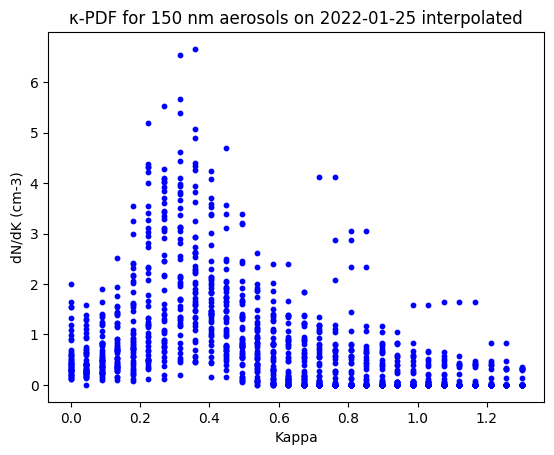

In [230]:
plt.scatter(df_k_150.K0, df_k_150.dNdK, s=10, c='b')
plt.xlabel("Kappa")
plt.ylabel("dN/dK (cm-3)")
plt.title(f"κ-PDF for 150 nm aerosols on {formatted_date} interpolated")

Text(0.5, 1.0, 'κ-PDF for 150 nm aerosols on 2022-01-25')

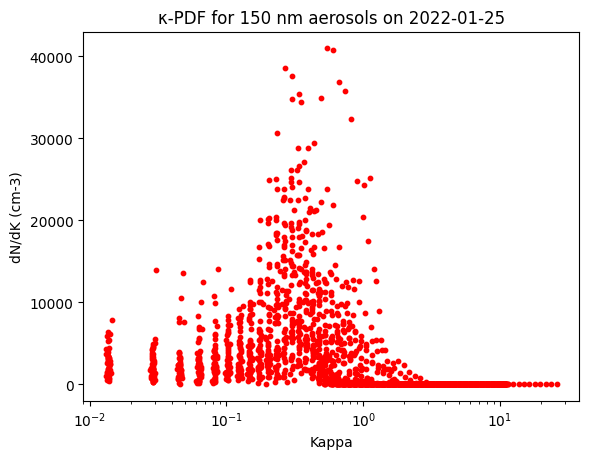

In [231]:
plt.scatter(newdf_150.kappa, newdf_150.conc_norm0, s=10, c='r')
plt.xlabel("Kappa")
plt.ylabel("dN/dK (cm-3)")
plt.xscale('log')
plt.title(f"κ-PDF for 150 nm aerosols on {formatted_date}")

Text(0.5, 1.0, 'κ-PDF for 150 nm aerosols on 2022-01-25')

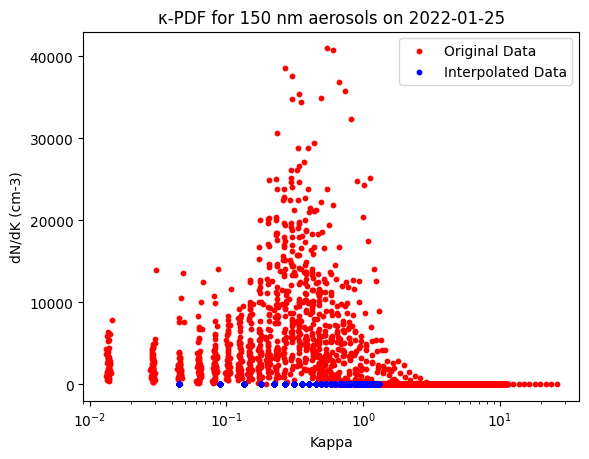

In [232]:
plt.scatter(newdf_150.kappa, newdf_150.conc_norm0, s=10, c='r', label='Original Data')
plt.scatter(df_k_150.K0, df_k_150.dNdK, s=10, c='b', label='Interpolated Data') # s => size, c => color
plt.xlabel("Kappa")
plt.ylabel("dN/dK (cm-3)")
plt.xscale('log')
plt.legend()
plt.title(f"κ-PDF for 150 nm aerosols on {formatted_date}")

In [233]:
df_k_150[0:60]

,dia,K0,dNdK,time
0,150.0,0.000000,2.005257,0.021667
1,150.0,0.044828,0.935199,0.021667
2,150.0,0.089655,1.206040,0.021667
3,150.0,0.134483,0.705710,0.021667
4,150.0,0.179310,2.177170,0.021667
5,150.0,0.224138,0.948794,0.021667
6,150.0,0.268966,2.155023,0.021667
7,150.0,0.313793,2.804946,0.021667
8,150.0,0.358621,1.581948,0.021667
9,150.0,0.403448,2.100145,0.021667


In [234]:
# i  = int(60+150*20)
i = 6810
df_k[i:i+60]

,dia,K0,dNdK,time
6810,250.0,0.000000,0.852689,23.919444
6811,250.0,0.044828,0.803777,23.919444
6812,250.0,0.089655,0.200023,23.919444
6813,250.0,0.134483,0.198033,23.919444
6814,250.0,0.179310,0.748542,23.919444
6815,250.0,0.224138,2.316344,23.919444
6816,250.0,0.268966,2.656360,23.919444
6817,250.0,0.313793,4.457986,23.919444
6818,250.0,0.358621,2.065501,23.919444
6819,250.0,0.403448,1.123081,23.919444


In [238]:
# index = 60
index = 0

size = df_k.dia[index]
time_i = df_k.time[index]
print("size:", size)
print("index:", index)
print('time_i:', time_i)

size: 150.0
index: 0
time_i: 0.021666666666666667


size: 150.0
index: 0
time_i: 0.021666666666666667


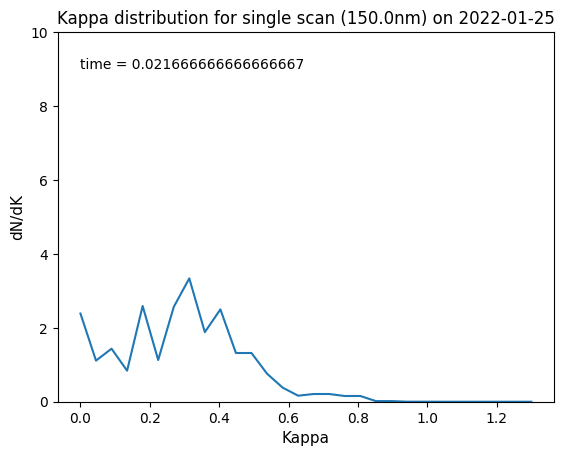

In [240]:
# index = 60
index = 0

size = df_k.dia[index]
time_i = df_k.time[index]
print("size:", size)
print("index:", index)
print('time_i:', time_i)

kappa_stand = df_k.K0
xaxis = kappa_stand[30:60].to_numpy()
conc_stand = df_k.dNdK
scan1 = conc_stand[index:index+30].to_numpy()
date_str = f"{date:8}"  # Convert to string for formatting
formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"  # YYYY-MM-DD
fig, ax = plt.subplots()
ax.plot(xaxis, scan1)
ax.set_xlabel('Kappa', fontsize=11)
ax.set_ylabel('dN/dK', fontsize=11)
ax.set_title(f'Kappa distribution for single scan ({size}nm) on {formatted_date}')
ax.set_ylim(0,10)
ax.annotate(f'time = {time_i}', xy=(1.2, 8), xytext=(0.0, 9))
plt.show()
